In [1]:
import numpy as np

import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

from modules.visualization import bayesian_comparison

In [2]:
TYPE = 'non_smoothed'
CLUSTERING = 'rnn'

## DATA

In [4]:
df = pd.read_csv(f'data\\df_{TYPE}.csv')

df = df[df['nth_match'] > 95]
df = df[df[f'{CLUSTERING}_clusters'] != -1]

df = df[['account_id', 'position', 'region', f'{CLUSTERING}_clusters', 'gpm']]
df['gpm_centered'] = (df['gpm'] - df['gpm'].mean()) / df['gpm'].std()

df.head(20)

,account_id,position,region,rnn_clusters,gpm,gpm_centered
95,5296,BOTTOM,EUW1,0,548.243626,1.872053
96,5296,BOTTOM,EUW1,0,450.562891,0.636963
97,5296,MIDDLE,EUW1,0,393.711340,-0.081876
98,5296,BOTTOM,EUW1,0,398.974359,-0.015330
99,5296,BOTTOM,EUW1,0,438.119522,0.479628
195,8520,UTILITY,EUW1,4,341.444533,-0.742745
196,8520,UTILITY,EUW1,4,318.317757,-1.035164
197,8520,UTILITY,EUW1,4,268.301887,-1.667572
198,8520,UTILITY,EUW1,4,269.018868,-1.658506
199,8520,UTILITY,EUW1,4,287.038492,-1.430663


<AxesSubplot:ylabel='Density'>

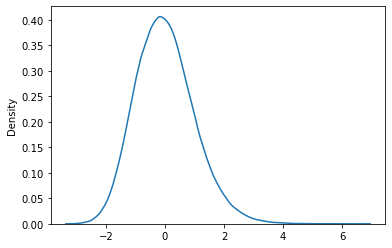

In [7]:
sns.kdeplot(
    df['gpm_centered'].values
)

<AxesSubplot:xlabel='rnn_clusters', ylabel='gpm_centered'>

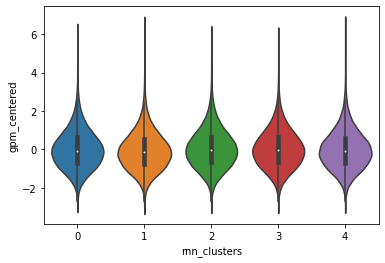

In [8]:
sns.violinplot(
    x=f'{CLUSTERING}_clusters',
    y='gpm_centered',
    data=df
)

In [9]:
df.groupby(f'{CLUSTERING}_clusters')['gpm_centered'].describe()

,count,mean,std,min,25%,50%,75%,max
rnn_clusters,,,,,,,,
0,203870.0,0.003879,1.004400,-3.088153,-0.703540,-0.057707,0.627208,6.366617
1,94010.0,-0.080675,0.977590,-3.166671,-0.771486,-0.141903,0.524996,6.711523
2,140870.0,0.039004,1.009730,-3.125717,-0.671603,-0.021303,0.671399,6.232019
3,200100.0,0.022785,1.001016,-3.147250,-0.681374,-0.031840,0.654629,6.178037
4,173235.0,-0.018820,0.994839,-3.123469,-0.719945,-0.081228,0.596690,6.753226


## BAYESIAN

## PyMC3 Set-up

In [10]:
account_unique = df['account_id'].unique()
account_mapping = {account: code for code, account in enumerate(account_unique)}
accounts = np.array([account_mapping[account] for account in df['account_id'].values])

positions_unique = df['position'].unique()
positions_mapping = {position: code for code, position in enumerate(positions_unique)}
positions = np.array([positions_mapping[position] for position in df['position'].values])

clusters_unique = [cluster for cluster in range(len(df[f'{CLUSTERING}_clusters'].unique()))]
clusters = df[f'{CLUSTERING}_clusters'].values

gpm = df['gpm_centered'].values

### Fixed-Intercept Model Pymc3

In [43]:
coords = {
    'Clusters': clusters_unique,
    'Observations': np.arange(gpm.size)
}

with pm.Model(coords=coords) as fixed_intercept_model:
    clusters_idx = pm.Data(
        'clusters_idx',
        clusters,
        dims='Observations'
    )
    
    fixed_intercept = pm.Normal(
        mu=0,
        sd=1,
        name='Fixed Intercept'
    )

    slope_cluster = pm.Normal(
        mu=0,
        sd=1,
        name='Slope Clusters',
        dims='Clusters'
    )

    outcome_mu = pm.Deterministic(
        'Mu = Fixed Intercept + Slope Clusters',
        fixed_intercept + slope_cluster[clusters_idx]
    )
    outcome_sd = pm.HalfCauchy(
        beta=1,
        name='Outcome Sigma'
    )
    outcome_nu = pm.Gamma(
        alpha=2,
        beta=0.1,
        name='Outcome Nu'
    )
    
    outcome = pm.StudentT(
        mu=outcome_mu,
        sd=outcome_sd,
        nu=outcome_nu,
        name='Outcome',
        observed=gpm
    )

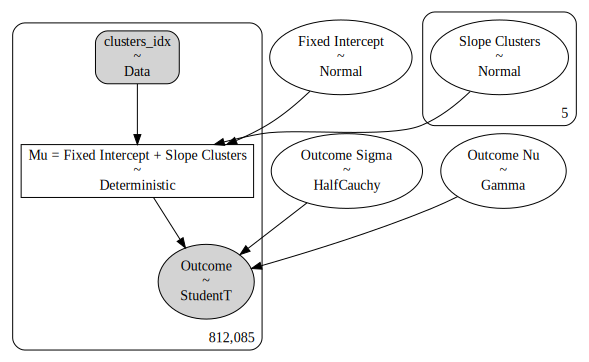

In [44]:
with fixed_intercept_model:
    
    plate = pm.model_graph.model_to_graphviz()

plate

In [45]:
with fixed_intercept_model:
    
    fixed_intercept_gener = pm.fit(
        n=10000
    )

Interrupted at 565 [5%]: Average Loss = 1.8515e+06


In [46]:
fixed_intercept_traces = fixed_intercept_gener.sample(1000)

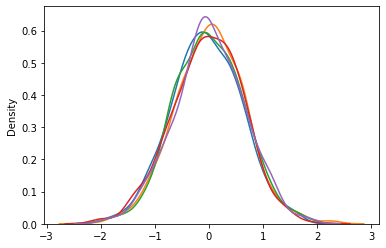

In [47]:
for i in range(5):
    
    sns.kdeplot(
        fixed_intercept_traces['Slope Clusters'][:, i]
    )

### Random-Intercept Position Model PyMC3

In [25]:
coords = {
    'Positions': positions_unique,
    'Clusters': clusters_unique,
    'Observations': np.arange(gpm.size)
}

with pm.Model(coords=coords) as random_position_model:
    position_idx = pm.Data(
        'positions_idx',
        positions,
        dims='Observations'
    )
    clusters_idx = pm.Data(
        'clusters_idx',
        clusters,
        dims='Observations'
    )
     
    # HYPER-PRIORS
    
    # POSITION
    hyper_sd_position = pm.HalfCauchy(
        beta=1,
        name='Hyper Sigma Position'
    )
    hyper_mu_position = pm.Normal(
        mu=0,
        sigma=1,
        name='Hyper Mu Position'
    )
        
    
    # Build Intercept
    # POSITION
    position_theta_tilde = pm.Normal(
        mu=0,
        sd=1,
        name='Positions Varying Theta Tilde',
        dims='Positions'
    )
    position_theta = pm.Deterministic(
        'Positions Varying Theta',
        hyper_mu_position + hyper_sd_position * position_theta_tilde
    )
    
    # Look at the effect of clusters
    slope_cluster = pm.Normal(
        mu=0,
        sd=1,
        name='Slope Clusters',
        dims='Clusters'
    )
    
    # Create the model
    outcome_mu = pm.Deterministic(
        'Mu',
        position_theta[position_idx] + slope_cluster[clusters_idx]
    )
    outcome_sd = pm.HalfCauchy(
        beta=1,
        name='Outcome Sigma'
    )
    outcome_nu = pm.Gamma(
        alpha=2,
        beta=0.1,
        name='Outcome Nu'
    )
    
    outcome = pm.StudentT(
        mu=outcome_mu,
        sd=outcome_sd,
        nu=outcome_nu,
        name='Outcome',
        observed=gpm
    )

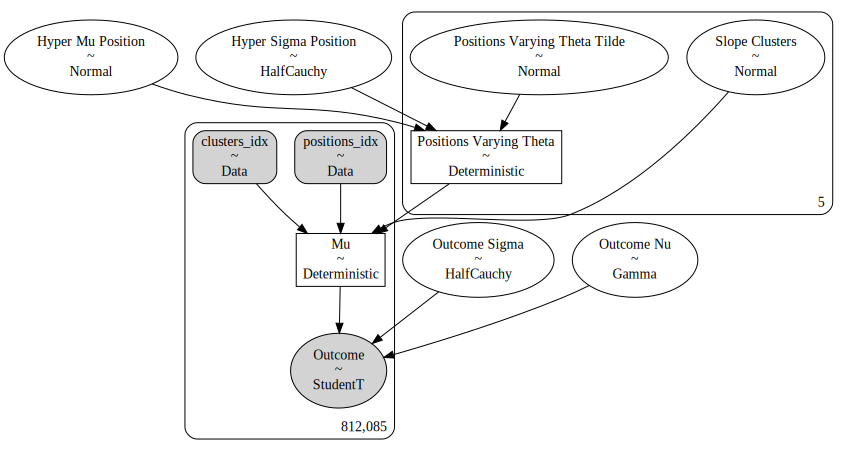

In [26]:
with random_position_model:
    
    plate = pm.model_graph.model_to_graphviz()

plate

In [27]:
with random_position_model:
    
    random_position_gener = pm.fit(
        n=10000
    )

Interrupted at 5,196 [51%]: Average Loss = 1.613e+06


In [28]:
random_position_traces = random_position_gener.sample(1000)

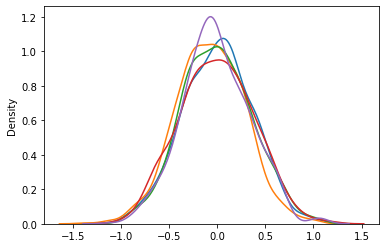

In [30]:
for i in range(5):
    
    sns.kdeplot(
        random_position_traces['Slope Clusters'][:, i]
    )

### Random-Intercept Account ID Model PyMC3

In [31]:
coords = {
    'Accounts': account_unique,
    'Clusters': clusters_unique,
    'Observations': np.arange(gpm.size)
}

with pm.Model(coords=coords) as random_accounts_model:
    account_idx = pm.Data(
        'account_idx',
        accounts,
        dims='Observations'
    )
    clusters_idx = pm.Data(
        'clusters_idx',
        clusters,
        dims='Observations'
    )
     
    # HYPER-PRIORS
    
    # ACCOUNTS
    hyper_sd_accounts = pm.HalfCauchy(
        beta=1,
        name='Hyper Sigma Accounts'
    )
    hyper_mu_accounts = pm.Normal(
        mu=0,
        sigma=1,
        name='Hyper Mu Accounts',
        
    )
    
    # build the intercept
    
    # BINS
    accounts_theta_tilde = pm.Normal(
        mu=0,
        sd=1,
        name='Accounts Varying Theta Tilde',
        dims='Accounts'
    )
    accounts_theta = pm.Deterministic(
        'Bins Varying Theta',
        hyper_mu_accounts + hyper_sd_accounts * accounts_theta_tilde
    )

    
    # Look at the effect of clusters
    slope_cluster = pm.Normal(
        mu=0,
        sd=1,
        name='Slope Clusters',
        dims='Clusters'
    )
    
    
    # Create the model
    outcome_mu = pm.Deterministic(
        'Mu',
        accounts_theta[account_idx] + slope_cluster[clusters_idx]
    )
    outcome_sd = pm.HalfCauchy(
        beta=1,
        name='Outcome Sigma'
    )
    outcome_nu = pm.Gamma(
        alpha=2,
        beta=0.1,
        name='Outcome Nu'
    )
    
    outcome = pm.StudentT(
        mu=outcome_mu,
        sd=outcome_sd,
        nu=outcome_nu,
        name='Outcome',
        observed=gpm
    )

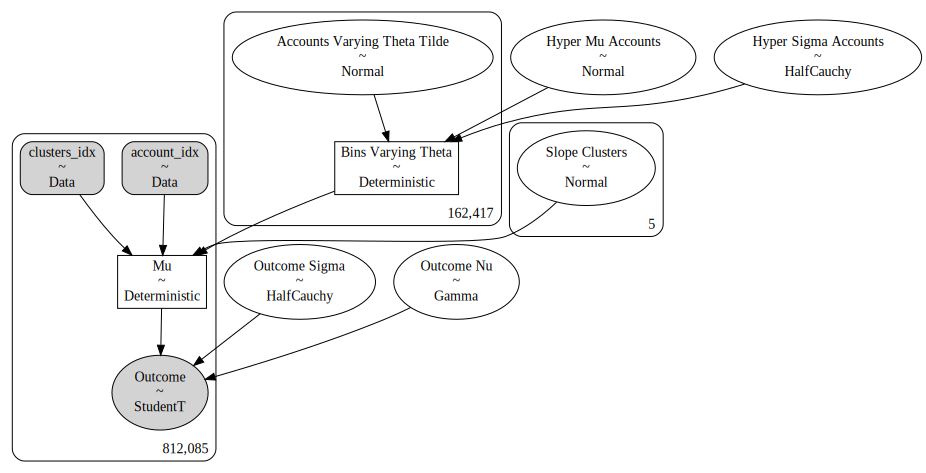

In [32]:
with random_accounts_model:
    
    plate = pm.model_graph.model_to_graphviz()

plate

In [33]:
with random_accounts_model:
    
    random_accounts_gener = pm.fit(
        n=10000
    )

Interrupted at 5,190 [51%]: Average Loss = 1.649e+06


In [34]:
random_accounts_traces = random_accounts_gener.sample(1000)

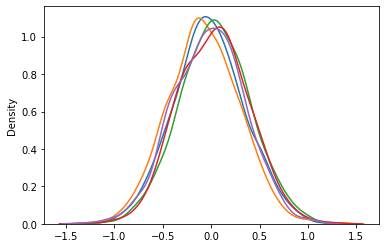

In [35]:
for i in range(5):
    
    sns.kdeplot(
        random_accounts_traces['Slope Clusters'][:, i]
    )

### Random-Intercept Position - Account ID -  PyMC3

In [38]:
coords = {
    'Accounts': account_unique,
    'Positions': positions_unique,
    'Clusters': clusters_unique,
    'Observations': np.arange(gpm.size)
}

with pm.Model(coords=coords) as random_pos_accounts_model:
    account_idx = pm.Data(
        'account_idx',
        accounts,
        dims='Observations'
    )
    position_idx = pm.Data(
        'positions_idx',
        positions,
        dims='Observations'
    )
    clusters_idx = pm.Data(
        'clusters_idx',
        clusters,
        dims='Observations'
    )
     
    # HYPER-PRIORS
    # BINS
    hyper_sd_accounts = pm.HalfCauchy(
        beta=1,
        name='Hyper Sigma Accounts'
    )
    hyper_mu_accounts = pm.Normal(
        mu=0,
        sigma=1,
        name='Hyper Mu Accounts',
        
    )
    
    # POSITION
    hyper_sd_position = pm.HalfCauchy(
        beta=1,
        name='Hyper Sigma Position'
    )
    hyper_mu_position = pm.Normal(
        mu=0,
        sigma=1,
        name='Hyper Mu Position',
        
    )    
    
    # build the intercept
    
    # ACCOUNTS
    accounts_theta_tilde = pm.Normal(
        mu=0,
        sd=1,
        name='Accounts Varying Theta Tilde',
        dims='Accounts'
    )
    accounts_theta = pm.Deterministic(
        'Bins Varying Theta',
        hyper_mu_accounts + hyper_sd_accounts * accounts_theta_tilde
    )
    
    # POSITION
    position_theta_tilde = pm.Normal(
        mu=0,
        sd=1,
        name='Positions Varying Theta Tilde',
        dims='Positions'
    )
    position_theta = pm.Deterministic(
        'Positions Varying Theta',
        hyper_mu_position + hyper_sd_position * position_theta_tilde
    )

    
    intercept = pm.Deterministic(
        'Varying Intercept',
        accounts_theta[account_idx] + position_theta[position_idx]
    )
    
    # Look at the effect of clusters
    slope_cluster = pm.Normal(
        mu=0,
        sd=1,
        name='Slope Clusters',
        dims='Clusters'
    )
    
    # Create the model
    outcome_mu = intercept + slope_cluster[clusters_idx]
    outcome_sd = pm.HalfCauchy(
        beta=1,
        name='Outcome Sigma'
    )
    outcome_nu = pm.Gamma(
        alpha=2,
        beta=0.1,
        name='Outcome Nu'
    )
    
    outcome = pm.StudentT(
        mu=outcome_mu,
        sd=outcome_sd,
        nu=outcome_nu,
        name='Outcome',
        observed=gpm
    )

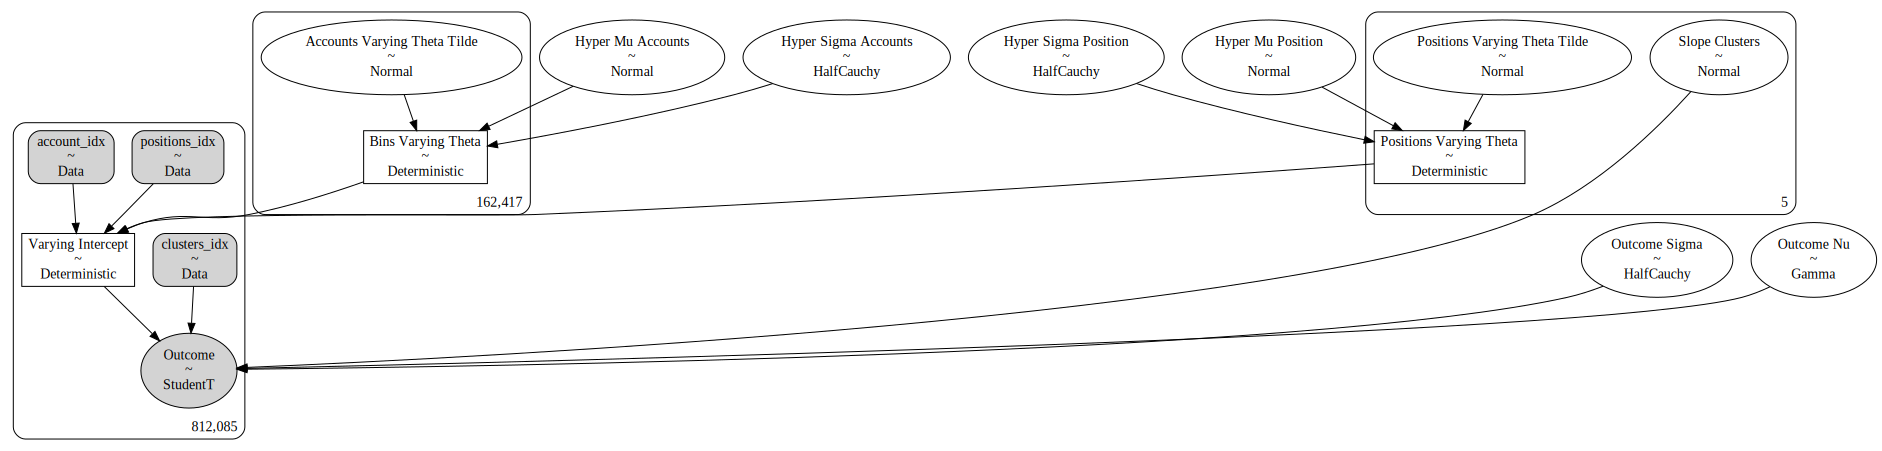

In [39]:
with random_pos_accounts_model:
    
    plate = pm.model_graph.model_to_graphviz()

plate

In [40]:
with random_pos_accounts_model:
    
    random_pos_accounts_gener = pm.fit(
        n=10000
    )

Interrupted at 224 [2%]: Average Loss = 3.0542e+06


In [41]:
random_pos_accounts_traces = random_pos_accounts_gener.sample(1000)

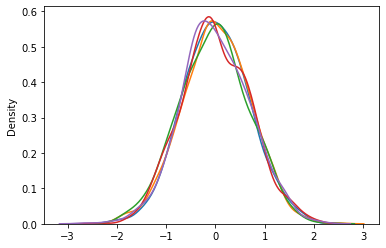

In [42]:
for i in range(5):
    
    sns.kdeplot(
        random_pos_accounts_traces['Slope Clusters'][:, i]
    )

## Model Comparison

In [49]:
compare_df = pm.compare(
    {
        'Fixed Intercept': fixed_intercept_traces, 
        'Random Position': random_position_traces,
        'Random Accounts': random_accounts_traces,
        'Random Position Accounts': random_pos_accounts_traces
    },
    scale='deviance'
)

C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


MemoryError: Unable to allocate 6.05 GiB for an array with shape (1000, 812085) and data type float64

In [ ]:
pm.compareplot(compare_df)

In [ ]:
compare_df